In [ ]:
%load_ext autoreload
%autoreload

In [1]:
from muxcnn.utils import *
from muxcnn.hecnn import *
from icecream import ic
import torch
import torch.nn.functional as F

In [2]:
################
#  unpack()    #
################
def plot_4x4(img, co=None, fn=None):
    fig, axs = plt.subplots(4,4, figsize=(8,8))
    axs = axs.ravel()
    vmin = img.min()
    vmax = img.max()
    if co is None:
        co = len(img)
    for ico in range(co):
        axs[ico].imshow(img[ico], vmin=vmin, vmax=vmax)
    plt.tight_layout()
    if fn is not None:
        plt.savefig(fn)
        plt.close()

## Torch model

In [3]:
def load_params(model, fn_param, device):
    trained_param = torch.load(fn_param, map_location = torch.device(device))
    trained_param = {key : value.cpu()   for key,value in trained_param.items()}
    params_np     = {key : value.numpy() for key,value in trained_param.items()}
    model.load_state_dict(trained_param)

def load_img(fname, hi=None, wi=None):
    image = cv2.imread(fname)
    if hi is not None and wi is not None:
        image = cv2.resize(image,(hi,wi))
    img = get_channel_first(image)
    img = torch.tensor(img).unsqueeze(0)
    return img.type(torch.FloatTensor)

In [4]:
from muxcnn.models.ResNet20 import ResNet, BasicBlock

activation = F.relu

model = ResNet(BasicBlock,[1,1,1])
load_params(model, fn_param="./ResNet8.pt",device='cpu')

In [5]:
model

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, e

In [6]:
img_tensor = load_img("./cute.jpg", hi=32, wi=32)

torch.Size([1, 16, 32, 32])


Text(0.5, 1.0, 'After bn1')

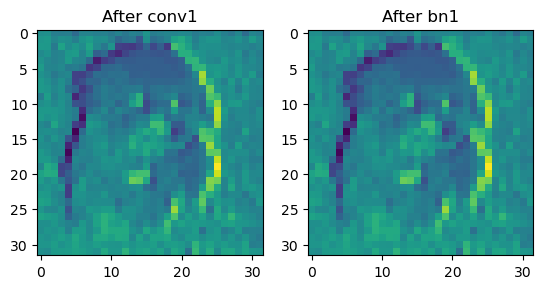

In [7]:
#img_tensor = convert_tensor(img)
res1 = model.conv1(img_tensor)
print(res1.shape)
fig, axs = plt.subplots(1,2)
axs[0].imshow(res1[0,0,:,:].detach().numpy())
axs[0].set_title("After conv1")

res2 = model.bn1(res1)
axs[1].imshow(res2[0,0,:,:].detach().numpy())
axs[1].set_title("After bn1")

# FHE-frinedly model

In [9]:
imgl = get_channel_last(img_tensor[0])
ki = 1
hi, wi, ch = imgl.shape

U, ins, outs = prepare_conv(model.conv1, ki=ki, hi=hi, wi=wi)
ct_a = MultPack(imgl, ins)

out, un = forward_conv(model.conv1, ct_a, ki, hi, wi)

[MultConv] (hi,wi,ci) =(32,32,3),(ho,wo,co)=(32,32,16),(fh,fw)=(3,3)
[MultConv] (ki,ti) =(1,3), (ko,to) =(1,16)


Text(0.5, 1.0, 'After conv1')

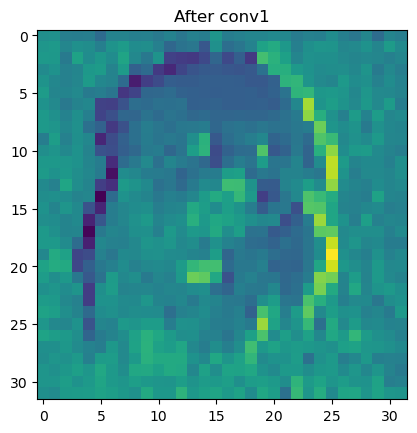

In [10]:
un = unpack(out,outs)

fig, ax = plt.subplots()
ax.imshow(un[0,:,:])
ax.set_title("After conv1")